In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from ase import Atoms
from ase.build import make_supercell
from quests.descriptor import get_descriptors
from quests.entropy import perfect_entropy, delta_entropy
from quests.tools.plotting import savefig
from quests.tools.example import get_reference_structures

# "paper" is not a valid style
# plt.style.use("paper")
plt.style.use("seaborn-v0_8-paper")

CUTOFF = 5
K = 32

## Comparing descriptors of different structures

In [22]:
fcc, bcc, hcp = get_reference_structures(supercell=4)
print(fcc)

def describe(struct):
    return get_descriptors([struct], k=K, cutoff=CUTOFF, concat=False)

descripts = {
    "fcc": describe(fcc),
    "bcc": describe(bcc),
    "hcp": describe(hcp),
}

colors = {
    "fcc": cm.tab10(0),
    "bcc": cm.tab10(1),
    "hcp": cm.tab10(2),
}

Atoms(symbols='Cu64', pbc=True, cell=[[0.0, 7.16, 7.16], [7.16, 0.0, 7.16], [7.16, 7.16, 0.0]])


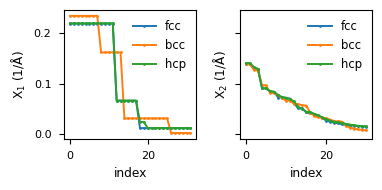

In [4]:
fig, ax_fig = plt.subplots(1, 2, figsize=(4, 2), sharey=True)

for name, (r, d) in descripts.items():
    ax_fig[0].plot(r[0], "o-", color=colors[name], markersize=2, label=name)
    ax_fig[1].plot(d[0], "o-", color=colors[name], markersize=2, label=name)

ax = ax_fig[0]
ax.set_xlabel("index")
ax.set_ylabel("X$_1$ (1/Å)")
ax.legend(frameon=False, fontsize="small")

ax = ax_fig[1]
ax.set_xlabel("index")
ax.set_ylabel("X$_2$ (1/Å)")
ax.legend(frameon=False, fontsize="small")

plt.tight_layout()
savefig(fig, "01-x-view.pdf", prefix="figs")
plt.show()

In [5]:
x_fcc = get_descriptors([fcc])
x_bcc = get_descriptors([bcc])

In [6]:
delta_entropy(x_bcc, x_fcc).mean()

np.float64(89.39795789354315)

## Behavior under finer strain

In [7]:
fracs = np.arange(0.95, 1.05, 0.002).round(2)

descripts = {}
xs = {}
for strain in fracs:
    fcc, _, _ = get_reference_structures(strain, supercell=5)
    r, d = describe(fcc)
    
    descripts[strain] = (r[0], d[0])
    xs[strain] = np.concatenate([r[0], d[0]])


ref_x = xs[1.0]
distances_fcc = pd.Series({
    k - 1: np.linalg.norm(x - ref_x)
    for k, x in xs.items()
})

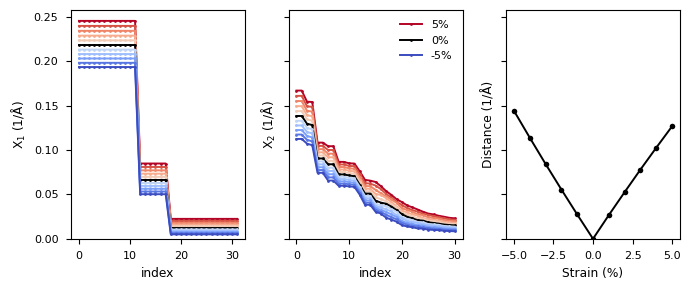

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(7, 3), sharey=True)

norm = plt.Normalize(fracs.min(), fracs.max())
cmap = lambda x: cm.coolwarm_r(norm(x))

for strain, (r, d) in descripts.items():
    color = "k" if np.isclose(strain, 1.0) else cmap(strain)
    axs[0].plot(r, "o-", color=color, markersize=2)

    if strain in [0.95, 1.0, 1.05]:
        axs[1].plot(d, "o-", color=color, markersize=2, label=f"{(1 - strain) * 100:0.0f}%")
    else:
        axs[1].plot(d, "o-", color=color, markersize=2)

ax = axs[0]
ax.set_xlabel("index")
ax.set_ylabel("X$_1$ (1/Å)")

ax = axs[1]
ax.set_xlabel("index")
ax.set_ylabel("X$_2$ (1/Å)")
ax.legend(frameon=False)

ax = axs[2]
ax.plot(distances_fcc.index * 100, distances_fcc.values, "ko-", markersize=4)
ax.set_ylabel("Distance (1/Å)")
ax.set_xlabel("Strain (%)")
ax.set_ylim(bottom=0)

fig.tight_layout()
savefig(fig, "01-x-strain.pdf", prefix="figs")
plt.show()